In [341]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [342]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to size.


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. size - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param size: number of points (data instances) in data set
@param r: tuple describing range in which regressors (feature) will be generated

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List[float], k:int, size:int=50, r:tuple = (0, 10)) -> List[List[float]]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = np.random.rand(size, dim) * (r[1] - r[0]) + r[0]
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = np.sum(b * regressors, axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from minimized function to one point from dataset)
"""
def generate_minimized_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List[float]], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i], len(t))
        # or
        # sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(np.sum(a * np.concatenate(([1], t))) - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
Similar to generate_minimized_fun but every regressor is 1 dimensional vector (i.e. minimized function has two arguments). You should use this function only when it's necessary to plot minimized function. Function generated by generate_minimized_two_variable_fun works fine when arguments are arrays unlike generate_minimized_fun.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from generated function to one point from dataset)
"""
def generate_minimized_two_variable_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List[float]], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + a[1] * t - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function from terms. Every term is function. Every function from terms should accept equal amount of parameters.

@return function representing sum of functions from terms
"""
def fun_from_terms(terms:List[Callable[[List[float]], float]]) -> Callable[[List[float]], float]:
    return reduce(lambda f1, f2: lambda x: f1(x) + f2(x), terms)

class StandartScaler:
    """
    Offers functionality to perform standart scaling.

    Works perfect when data generated by generate_dataset function.

    @param t: list of data instances to calculate mean and deviation for
    """
    def __init__(self, t:ndarray):
        self.mean = np.mean(t, axis=0)
        self.deviation = np.std(t, axis=0)

    """
    Scales features (regressors) in data instances. Mean and standard deviation after scaling equals to 0 and 1 respectively.

    @param t: list of data instances

    @return list of data instances with scaled features
    """
    def scale(self, t:ndarray) -> ndarray:
        return (t - self.mean) / self.deviation

    """
    Do reverse scaling.

    @param t: list of scaled data instances

    @return list of data instances before scale
    """
    def scale_reverse(self, t:ndarray) -> ndarray:
        return t * self.deviation + self.mean

    """
    Calculates min point of function with unscaled data instances using min point of function with scaled data instances

    @param min_point: scaled min point

    @return initial min point
    """
    def reverse_min_point(self, min_point:ndarray) -> ndarray:
        return np.concatenate([min_point[0] - min_point[1:] * self.mean / self.deviation, min_point[1:] / self.deviation])

"""
! Deprecated
Scales features (regressors) in data instances. Every feature value is in range [r[0], r[1]] after scaling.

As data set returned from generate_dataset distributed normally within each feature, it is better to do NOT use this scale if data set generated with generate_dataset.

@param t: list of data instances

@return list of data instances with scaled features
"""
def min_max_scale(t, r=(0, 1)):
    return (t - np.min(t, axis=0)) / (np.max(t, axis=0) - np.min(t, axis=0)) * (r[1] - r[0]) + r[0]

"""
Plots level lines of two variable function represented by terms.

@param terms: list of terms of plotted function (should be result of generate_minimized_two_variable_fun)
@param points: list of points at which plot level lines
@param offset: characterizes scale of the plot
"""
def plot_path_contours(terms:List[Callable[[List[float]], float]], points:List[List[float]], offset:float=None) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-')
    fun = fun_from_terms(terms)
    if offset is None:
        offset = np.max(min_point) * 1.2
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    plt.title('SGM path and level curves', fontsize=22)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])))

"""
Plots 2d plot of two variable linear function represented by fun_coeffs. fun_coeffs[0] represents height offset.
"""
def plot_dataset_and_function(t:List[List[float]], ft:List[float], fun_coeffs:List[float]) -> None:
    ax = plt.figure().add_subplot()
    ax.plot(t, ft, 'o', markersize=1)
    tt = np.linspace(np.min(t), np.max(t), 1000)
    plt.title('Data set and evaluated function', fontsize=22)
    ax.plot(tt, fun_coeffs[1] * tt + fun_coeffs[0])

"""
Plots how SGD approach to minimum point along each coordinate.
"""
def plot_convergence(points:ndarray) -> None:
    ax = plt.figure().add_subplot()
    plt.title('Convergence plot', fontsize=22)
    ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
    ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

"""
Prints data describing effectiveness of SGD.

@param actual_min: real minimum point of evaluated function
@param point: path of SGD
"""
def print_result(actual_min:ndarray, points:ndarray, min_point:float=None) -> None:
    if min_point is None:
        min_point = points[-1]
    print(f'Precision: {actual_min - min_point}')
    print(f'Min point: {min_point}')
    print(f'Path: {points}')

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@return list of points representing path of sgd. The last point of the list is found minimum point.
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    for i in range(1, epoch):
        x = x - 1 / batch_size * scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        points[i] = x
    return points

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

Precision: [-0.17629709 -0.20218257]
Min point: [10.17629709 -3.79781743]
Path: [[ 0.          0.        ]
 [ 2.00726612 -1.29560909]
 [ 2.78062878 -2.04311274]
 [ 3.95298779 -2.61002357]
 [ 5.25939492 -3.12825973]
 [ 6.27237911 -3.45053275]
 [ 6.9499613  -3.74809089]
 [ 8.0582601  -3.9208814 ]
 [ 8.32290249 -3.90915077]
 [ 8.45186917 -4.00192698]
 [ 8.68800086 -3.96778506]
 [ 8.77326735 -3.99361448]
 [ 8.89005343 -3.85570961]
 [ 9.13578892 -3.97164955]
 [ 9.5764162  -3.91130147]
 [ 9.75395419 -3.88423891]
 [10.2547032  -3.84300356]
 [ 9.97316321 -3.78660322]
 [ 9.92500407 -3.85741874]
 [10.17629709 -3.79781743]]


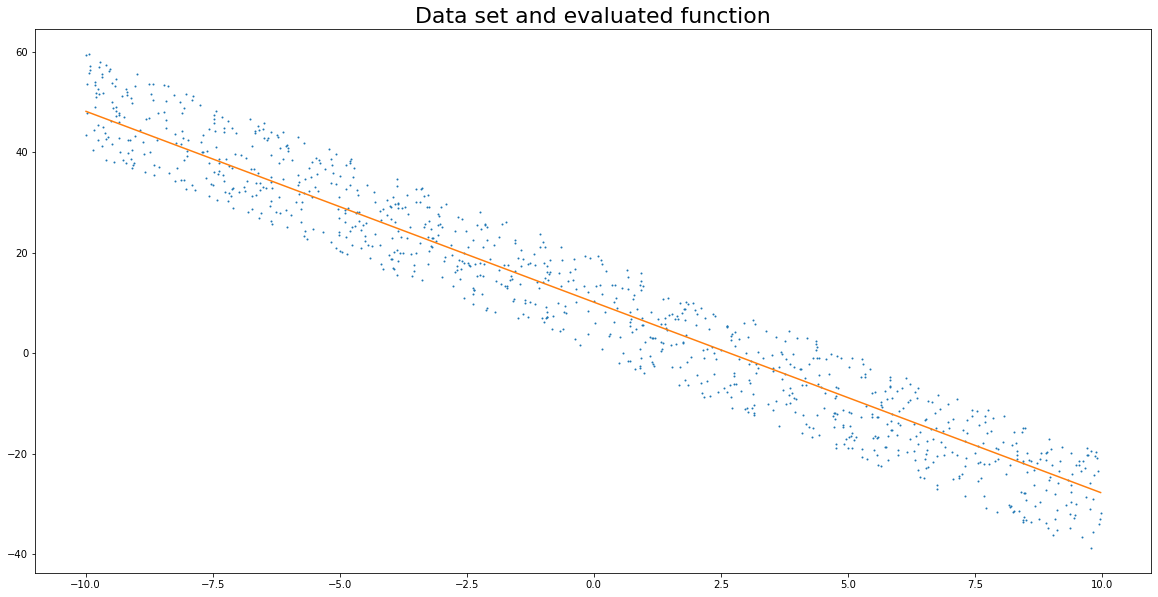

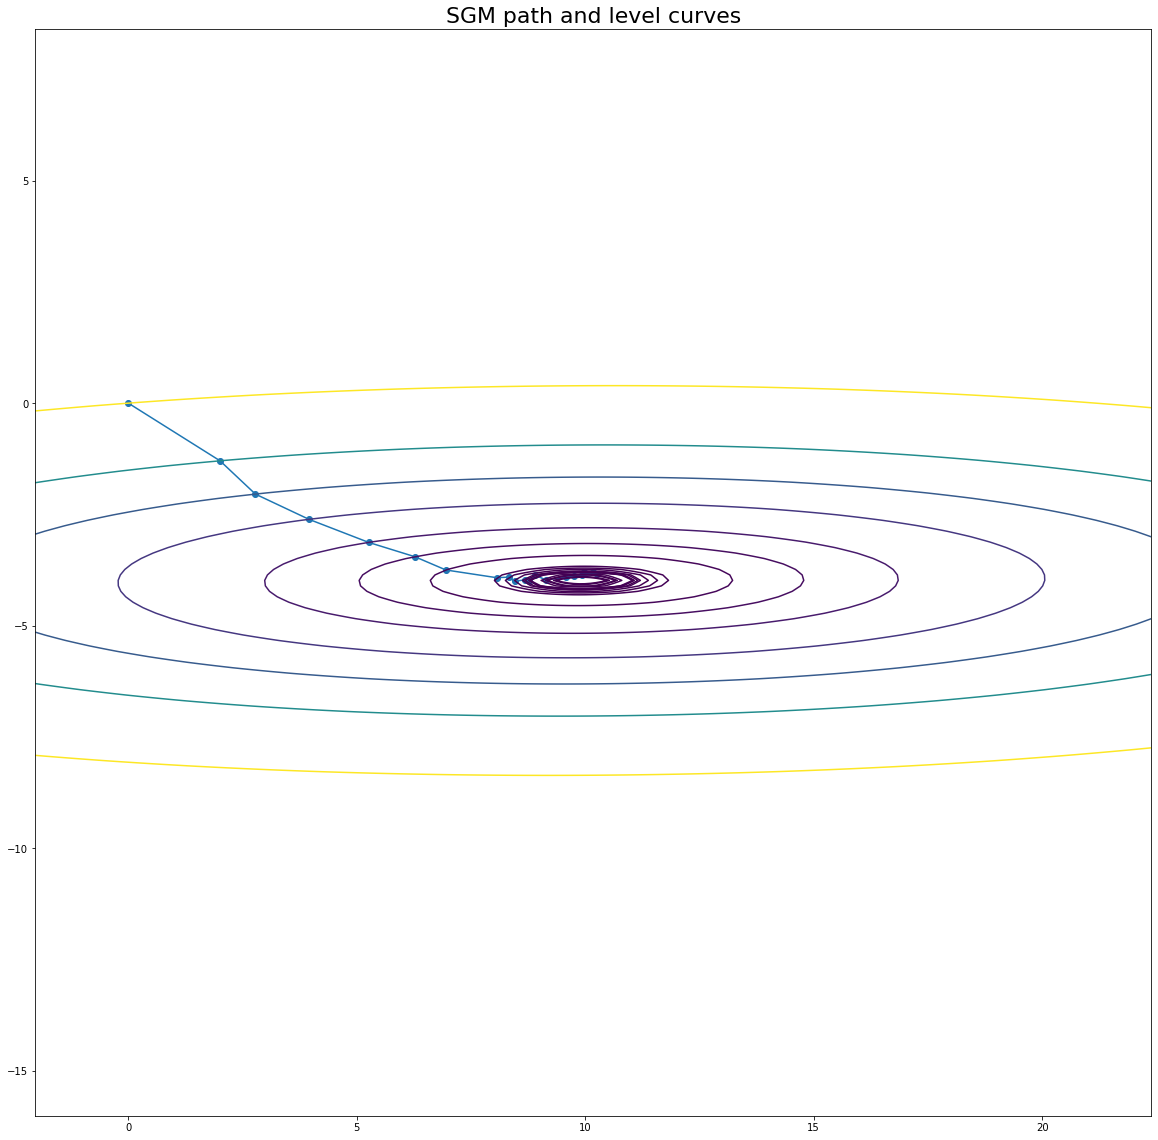

In [343]:
a = [10, -4]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [150, 8]

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

Precision: [0.19361469 0.03138401 0.03867769]
Min point: [9.80638531 1.96861599 3.96132231]
Path: [[ 0.          0.          0.        ]
 [ 1.08047318  0.12629264  0.85869402]
 [ 2.10380448  0.37579754  1.34345404]
 [ 3.25602183  0.56372272  1.70485908]
 [ 4.64989572  0.77263388  2.25318595]
 [ 5.66010917  1.02579436  2.73224818]
 [ 6.76633331  1.21229286  3.26129661]
 [ 6.92587696  1.23556963  3.4344032 ]
 [ 7.62249908  1.37103234  3.65888533]
 [ 8.27404082  1.47655276  3.73701029]
 [ 8.35597227  1.49120409  3.76999932]
 [ 8.60735837  1.58101273  3.92382323]
 [ 8.78802739  1.62290304  3.93788163]
 [ 8.92644903  1.65957753  3.84601963]
 [ 9.22466437  1.72521973  3.792961  ]
 [ 9.33199123  1.8205637   3.87455208]
 [ 9.24683631  1.87823314  3.94636765]
 [ 9.31627653  1.88929762  4.02106867]
 [ 9.47829803  1.88561296  3.91378724]
 [ 9.68480696  1.90418722  3.89552324]
 [ 9.69091195  1.89192626  3.87891798]
 [10.03592313  1.96630634  4.04799143]
 [10.28573082  1.96981722  4.02167548]
 [10.

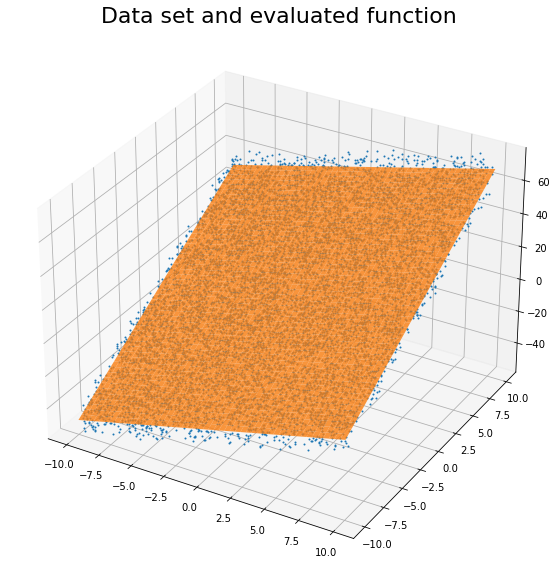

In [344]:
a = [10, 2, 4]
t, ft = generate_dataset(a, 10, 10000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [1500, 40, 80]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print_result(a, points)
ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
plt.title('Data set and evaluated function', fontsize=22)
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
tt = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [345]:
a = [10, 2, 4, 5, -3]
t, ft = generate_dataset(a, 10, 100000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [7500, 120, 160, 200, 120]

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)

Precision: [-0.18368323  0.24284502  0.79926578  0.25702364 -0.30936333]
Min point: [10.18368323  1.75715498  3.20073422  4.74297636 -2.69063667]
Path: [[ 0.          0.          0.          0.          0.        ]
 [ 4.57366895  0.01839381  0.43837228  0.81811092 -0.35532223]
 [ 3.66371365  0.09605796  0.67319297  0.62833493 -0.46868339]
 [ 3.69770732  0.08900671  0.51115065  0.8901347  -0.53278962]
 [ 3.32259758  0.19438729  0.9427557   0.94267165 -0.63135748]
 [ 2.43758114  0.24136123  0.88704187  1.11148009 -0.73752843]
 [ 4.29802875  0.18960218  0.80457222  1.44969259 -0.86897606]
 [ 4.80480232  0.17798726  0.94714834  1.60852797 -0.78153815]
 [ 5.35037884  0.14664897  1.05735087  1.53854546 -0.93091248]
 [ 6.26164108  0.1610556   1.26463295  1.70143151 -0.80686626]
 [ 6.78464039  0.16048691  1.33529774  1.9481293  -0.83461068]
 [ 6.8285968   0.27943371  1.16445034  2.29951985 -0.94993184]
 [ 5.47970412  0.31393095  1.2688498   2.37910984 -1.05279143]
 [ 5.5240923   0.20962446  1.

## 100-мерное пространство регрессоров

In [346]:
n = 101
a = np.random.randint(-10, 10, n)
t, ft = generate_dataset(a, 10, 1000000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(n)
epoch = 50
batch_size = 20
lr = 120

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)

Precision: [-4.01319137  1.68176376 -5.79156403 -7.10300839 -0.66737992  3.32213837
  4.42837627  4.02217069  1.28997086 -8.03396532  7.60361707 -7.18682265
 -0.4919879  -3.78937571  5.28521398 -3.33156927 -4.5418945  -7.20415914
 -6.86546796  5.78035127  5.06395887 -5.77783634  7.63569236 -1.67341043
  7.74329937 -2.32538812  0.93053258  1.79088522 -2.04854142 -2.21794456
 -8.3485958   0.04399863  1.94636282 -7.26347255 -4.32011949  2.83814901
  0.80448841 -0.96620177 -4.27750819 -4.40004802  5.20023618  1.3124706
 -3.29929675  6.95686398 -5.1780917   6.98347033  0.13766411 -0.66208623
  0.44451286  3.68377205 -4.83799671  6.38223053 -1.21675177  2.31635111
 -7.41428559  2.55901021  5.86752684 -5.32245223  2.03535883 -3.73629859
  2.02793038  2.8713026   3.68234472  3.22382638 -4.28975008  4.55366876
  0.41653126 -3.42717219  7.42533328  1.77906505 -0.88986262  7.54081735
  3.43297671  6.64938623  2.49063351  0.11775803 -6.49980152 -4.18702407
  5.19704869 -7.4420187   7.91635807 -5.2

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров. Можно заметить, что с повышением размера batch графики отклонений становятся всё плавнее, стремясь к некоторой точке, близкой к нулю.

[[ 1.24175052 -0.49056722 -0.56102019]
 [-0.02419205 -0.56466547 -0.19851384]
 [ 0.64254615 -0.12950709  0.4558586 ]
 [ 0.57673381 -0.31230248  0.16874643]
 [ 0.4679509  -0.10731517  0.41757569]
 [ 0.39424807 -0.19663204  0.08708299]
 [ 0.58835778 -0.07955737  0.2507752 ]
 [ 0.21070092 -0.11244872  0.06259135]
 [ 0.70357016 -0.08531636  0.10082112]
 [ 0.19265331 -0.107297    0.09353447]
 [ 0.56421493 -0.10980032  0.07854368]
 [ 0.05283442 -0.10032767  0.19265304]
 [ 0.52091012 -0.12577869  0.06008185]
 [ 0.04923504 -0.10541832  0.20779715]
 [ 0.5266282  -0.132245    0.00835701]
 [ 0.13699372 -0.07421413  0.23961574]
 [ 0.41901399 -0.13119964  0.03640586]
 [ 0.16838114 -0.08195986  0.22419092]
 [ 0.3658397  -0.10645343  0.0441772 ]
 [ 0.22634225 -0.08933008  0.19906247]
 [ 0.42752287 -0.10719822  0.05868238]
 [ 0.28554066 -0.07316112  0.18997662]
 [ 0.40735484 -0.11032904  0.06013623]
 [ 0.25811408 -0.08267148  0.18513239]
 [ 0.35486515 -0.08399218  0.08169794]
 [ 0.25357319 -0.09643268

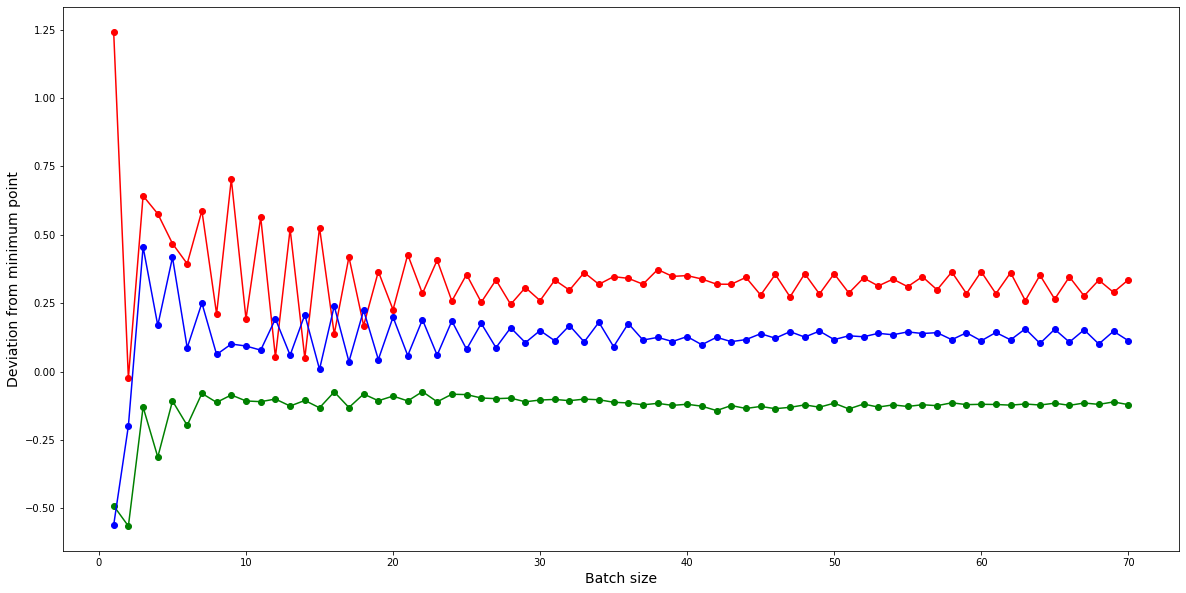

In [347]:
a = [25, 2, 15]
t, ft = generate_dataset(a, 10, 100, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
lr = [9, 0.5, 1]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

n = 70
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr)[-1])

min_points = np.array(min_points)
deviation = a - min_points
print(deviation)
print(min_points)

tt = np.linspace(1, n, n)
plt.gca().set_xlabel('Batch size', fontsize=14)
plt.gca().set_ylabel('Deviation from minimum point', fontsize=14)
plt.plot(tt, deviation[:, 0], '-o', color='red')
plt.plot(tt, deviation[:, 1], '-o', color='green')
plt.plot(tt, deviation[:, 2], '-o', color='blue')

## Решение задачи простой линейной регрессии с использованием standart scaler
Видно, что после scaling функция изменяется более одинаково по всем измерениям. Значительное улучшение сходимости. Отсутствие необходимости подбирать lr по каждой переменной.

Precision: [0.95153812 0.47562629]
Min point: [9.04846188 4.52437371]
Path: [[ 0.          0.        ]
 [ 1.95110287  4.65161495]
 [ 1.87125952  7.06274576]
 [ 2.74273797 10.16024866]
 [ 2.22685644 11.30906498]
 [ 2.59892067 13.26601211]
 [ 3.44750216 15.16795166]
 [ 3.59957033 17.20071575]
 [ 4.19849928 18.1227496 ]
 [ 4.82618348 19.30257585]
 [ 5.14377183 20.53157913]
 [ 5.66926641 21.62368044]
 [ 5.89458935 22.15538064]
 [ 6.13009518 22.97250946]
 [ 6.38050997 23.60855052]
 [ 6.5871297  24.06937501]
 [ 6.55233911 24.6311751 ]
 [ 6.70408913 25.10412491]
 [ 7.05265255 25.41221054]
 [ 7.47433047 25.96368834]]


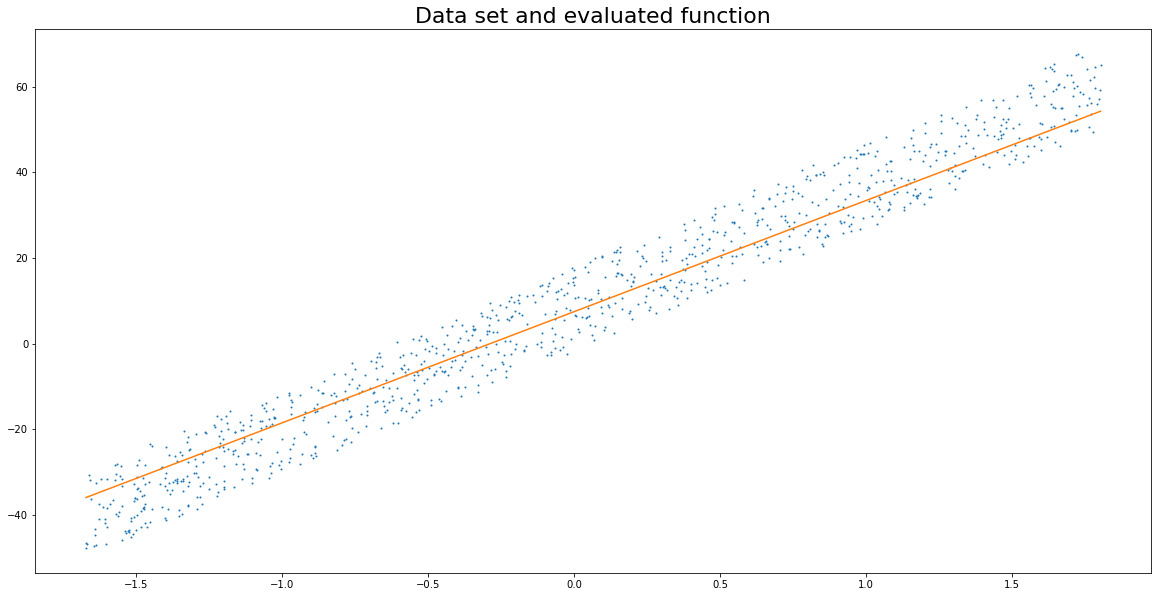

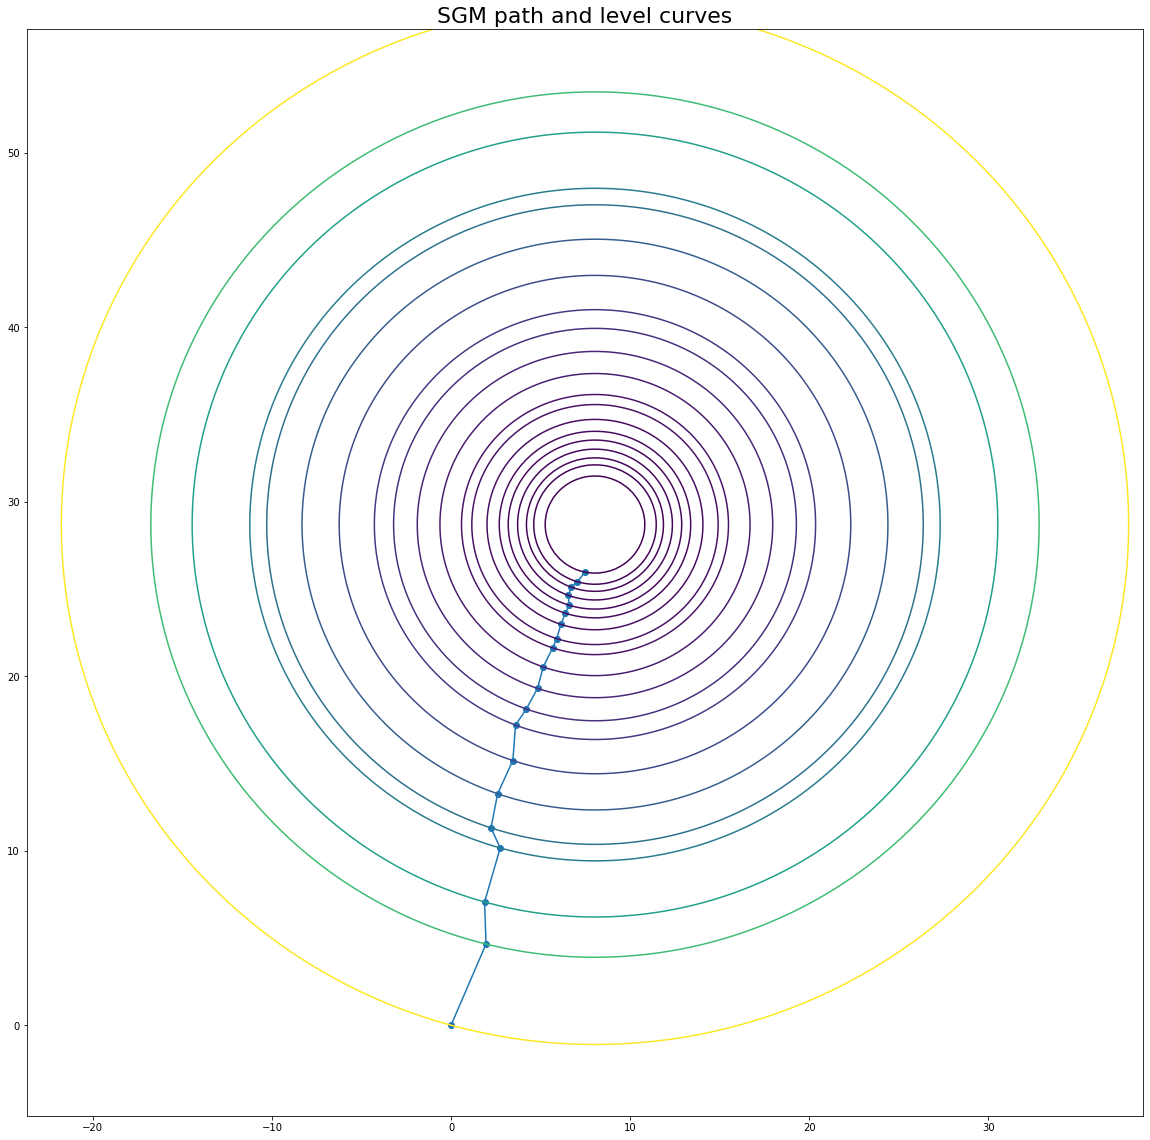

In [348]:
a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
scaler = StandartScaler(t)
t = scaler.scale(t)
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 120

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points, scaler.reverse_min_point(points[-1]))
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Сравнение до и после standart scaling

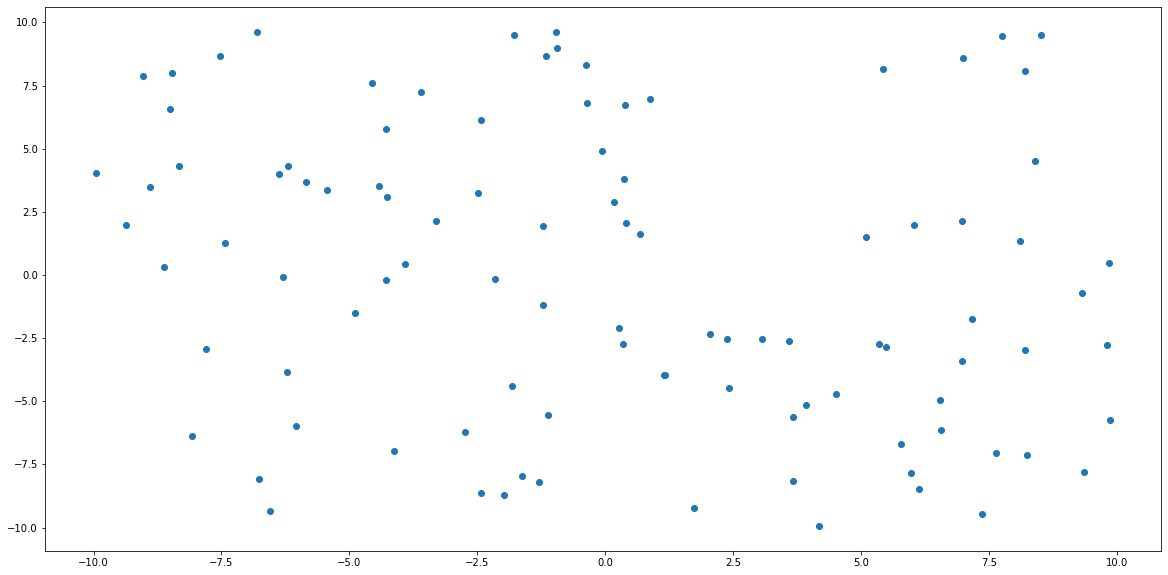

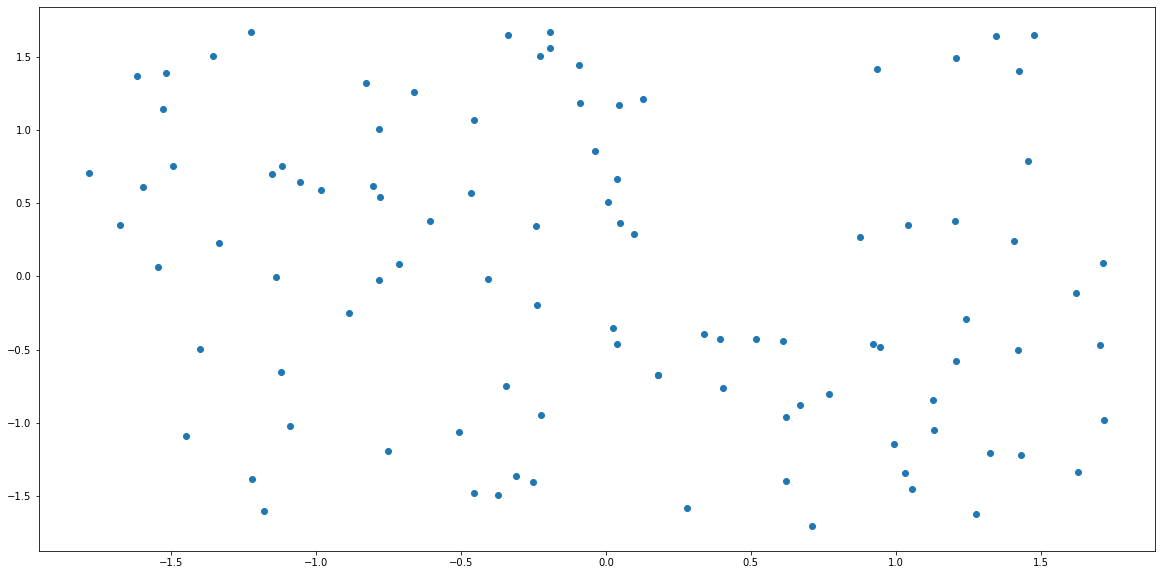

In [349]:
a = [10, -3, 5]
t = generate_dataset(a, 3, 100, (-10, 10))[0]

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

scaler = StandartScaler(t)
t = scaler.scale(t)

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

## SGM with momentum

Precision: [ 0.59425576 -0.12157677]
Min point: [9.40574424 5.12157677]
Path: [[0.         0.        ]
 [0.38875078 0.89646012]
 [0.87018291 2.25120936]
 [1.76694155 3.43453545]
 [2.64317551 4.18887286]
 [3.49896584 4.74028146]
 [4.30897234 5.11543328]
 [5.12038001 5.1937159 ]
 [5.68989794 5.2483249 ]
 [6.2086813  5.23471185]
 [6.78879212 5.14759766]
 [7.23193216 5.13489655]
 [7.77415326 5.04619433]
 [8.26579018 4.97900917]
 [8.57585847 4.92945943]
 [8.83811196 4.89315056]
 [9.08158319 4.89482914]
 [9.29691441 4.97959877]
 [9.40256857 5.03403347]
 [9.40574424 5.12157677]]


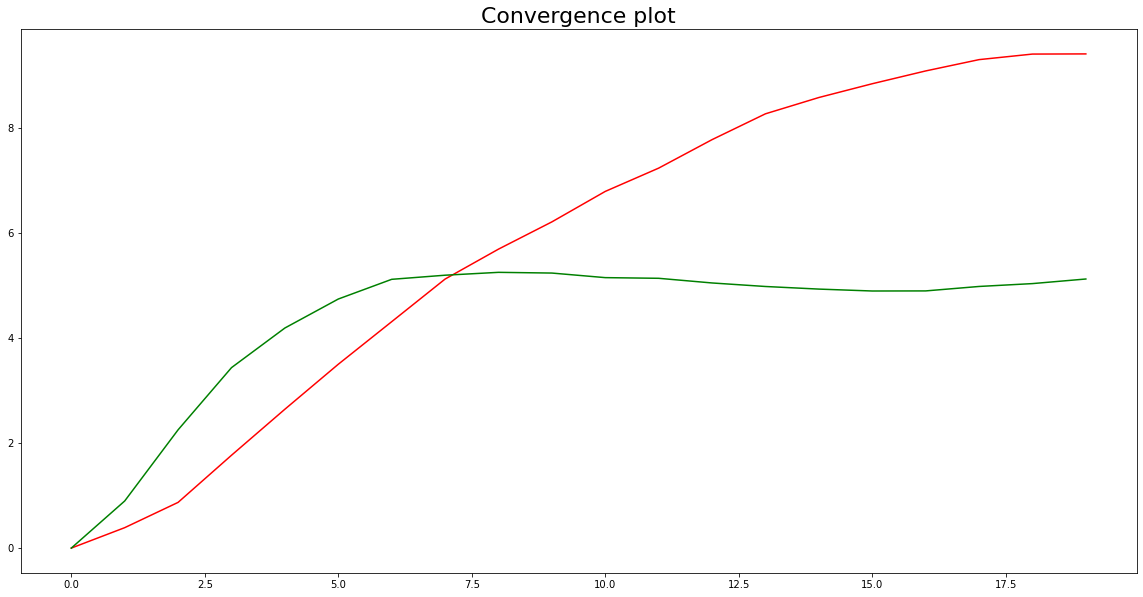

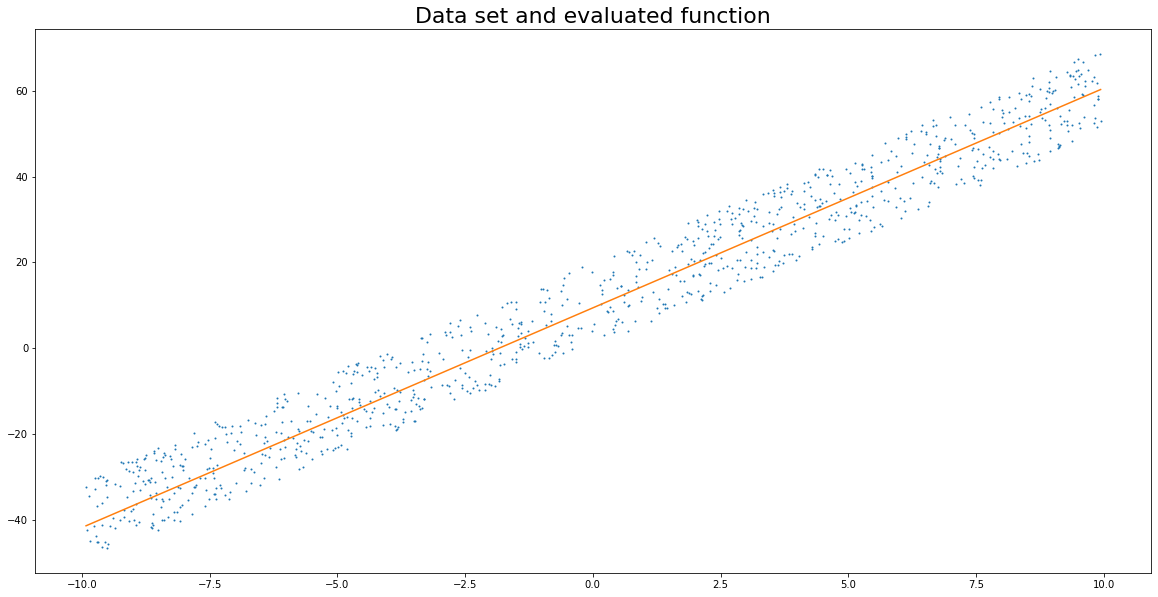

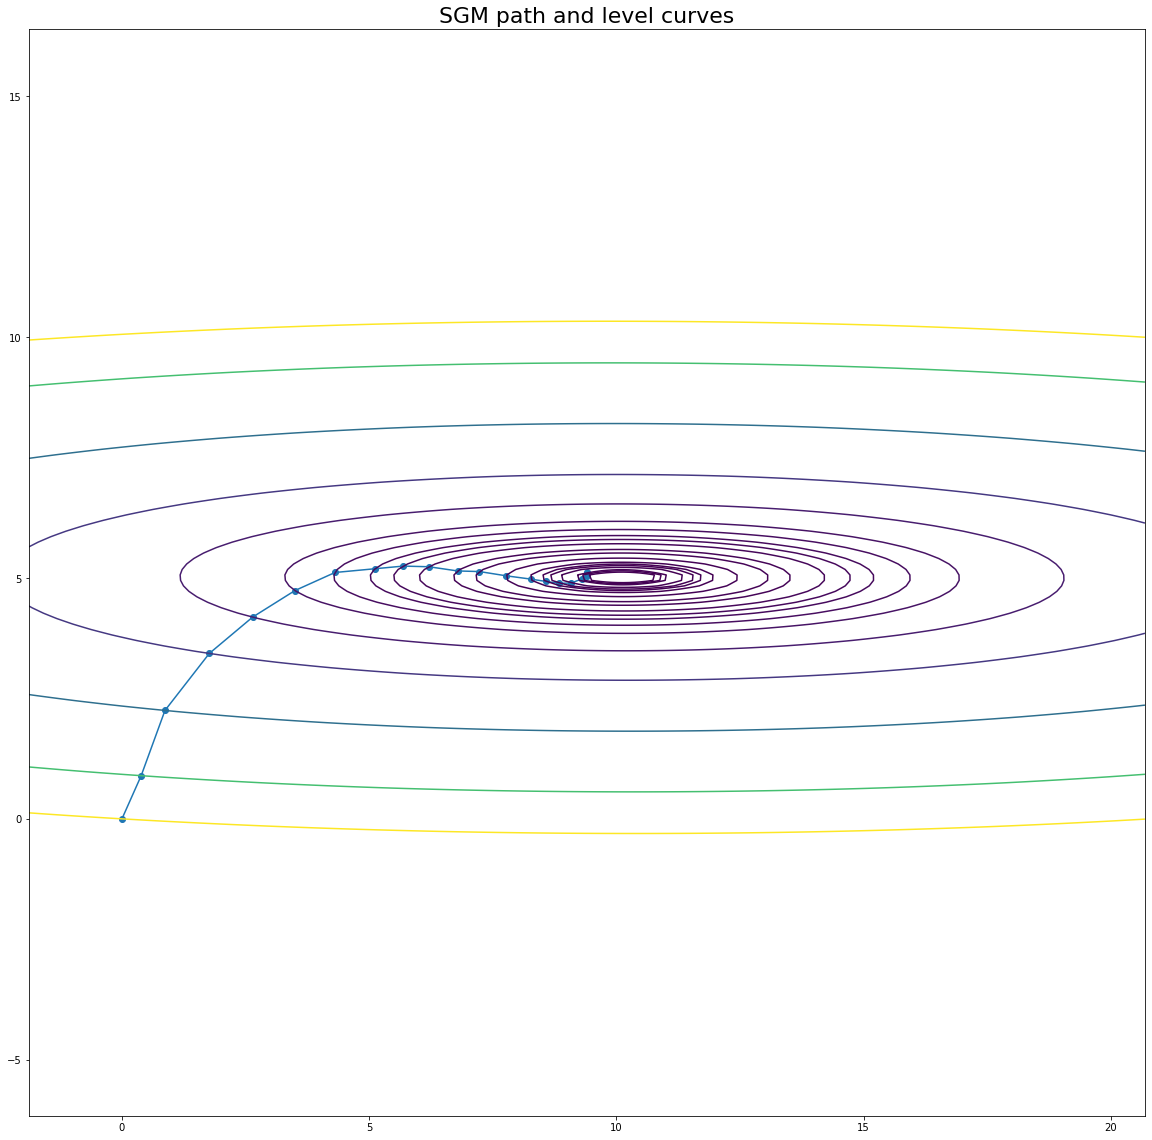

In [350]:
"""
Finds minimum of the function using stochastic gradient descent with momentum.

Отличие от обычного SGD в том, что добавился параметр b. Теперь при вычислении градиента в новой точке можно учитывать градиент во всех предыдущих. Чем дальше номер точки от текущего номера, тем меньший вклад градиент в ней вносит в текущий градиент. Такой подход призван предотвратить излишние колебания минимизируемой функции вблизи её минимума.

@param b: weight of gradient in previous points
"""
def sgd_momentum(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = np.zeros(len(x))
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [60, 5]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Nesterov SGD

Precision: [8.66143688 3.55834759]
Min point: [1.33856312 1.44165241]
Path: [[0.         0.        ]
 [0.0237471  0.16654218]
 [0.06773667 0.16548221]
 [0.10923639 0.28998872]
 [0.16728686 0.32685896]
 [0.22883822 0.45785284]
 [0.2933382  0.4926249 ]
 [0.36261845 0.61505592]
 [0.44077337 0.64486591]
 [0.51707296 0.76618043]
 [0.59421968 0.82464407]
 [0.67715854 0.91809528]
 [0.76389928 0.96561762]
 [0.85046115 1.05283928]
 [0.93457482 1.10771863]
 [1.017368   1.18947113]
 [1.10028615 1.2445427 ]
 [1.17955225 1.31955423]
 [1.25941591 1.36336443]
 [1.33856312 1.44165241]]


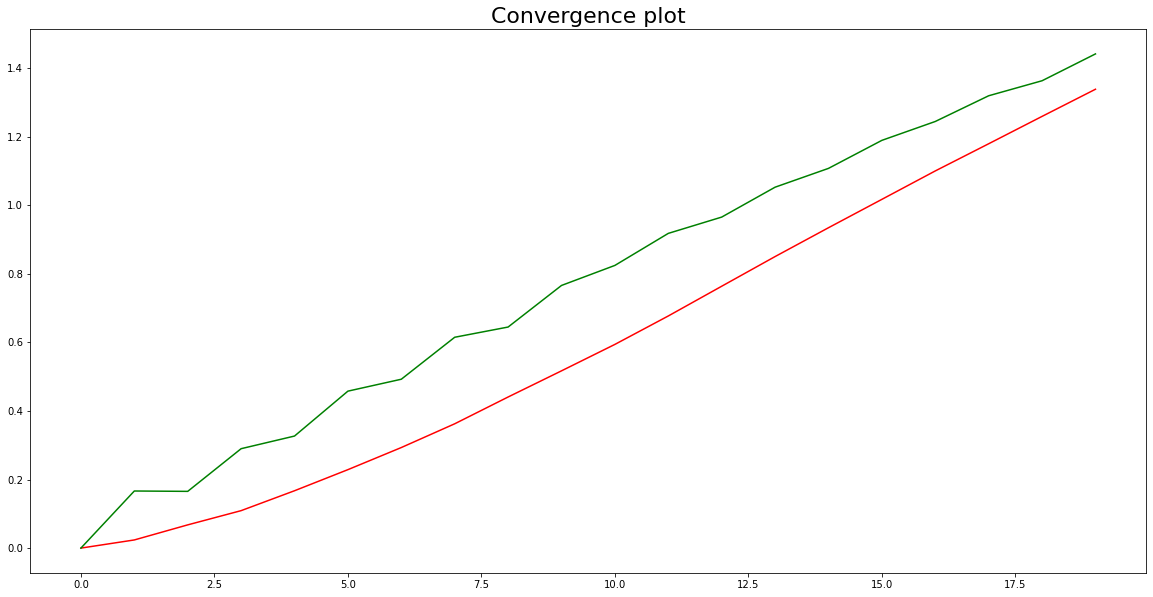

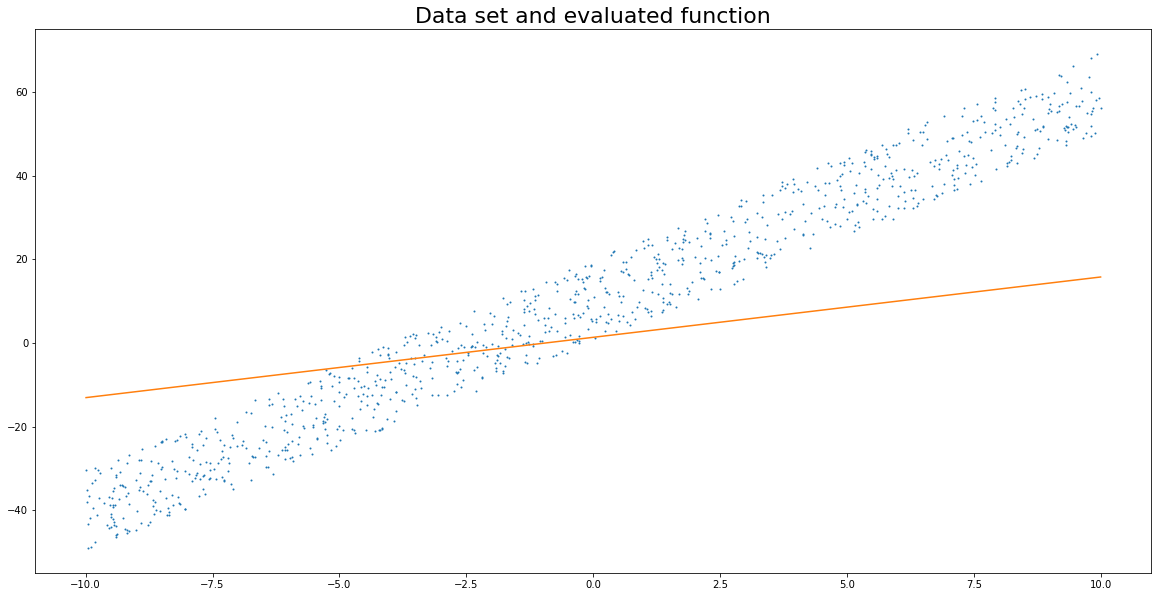

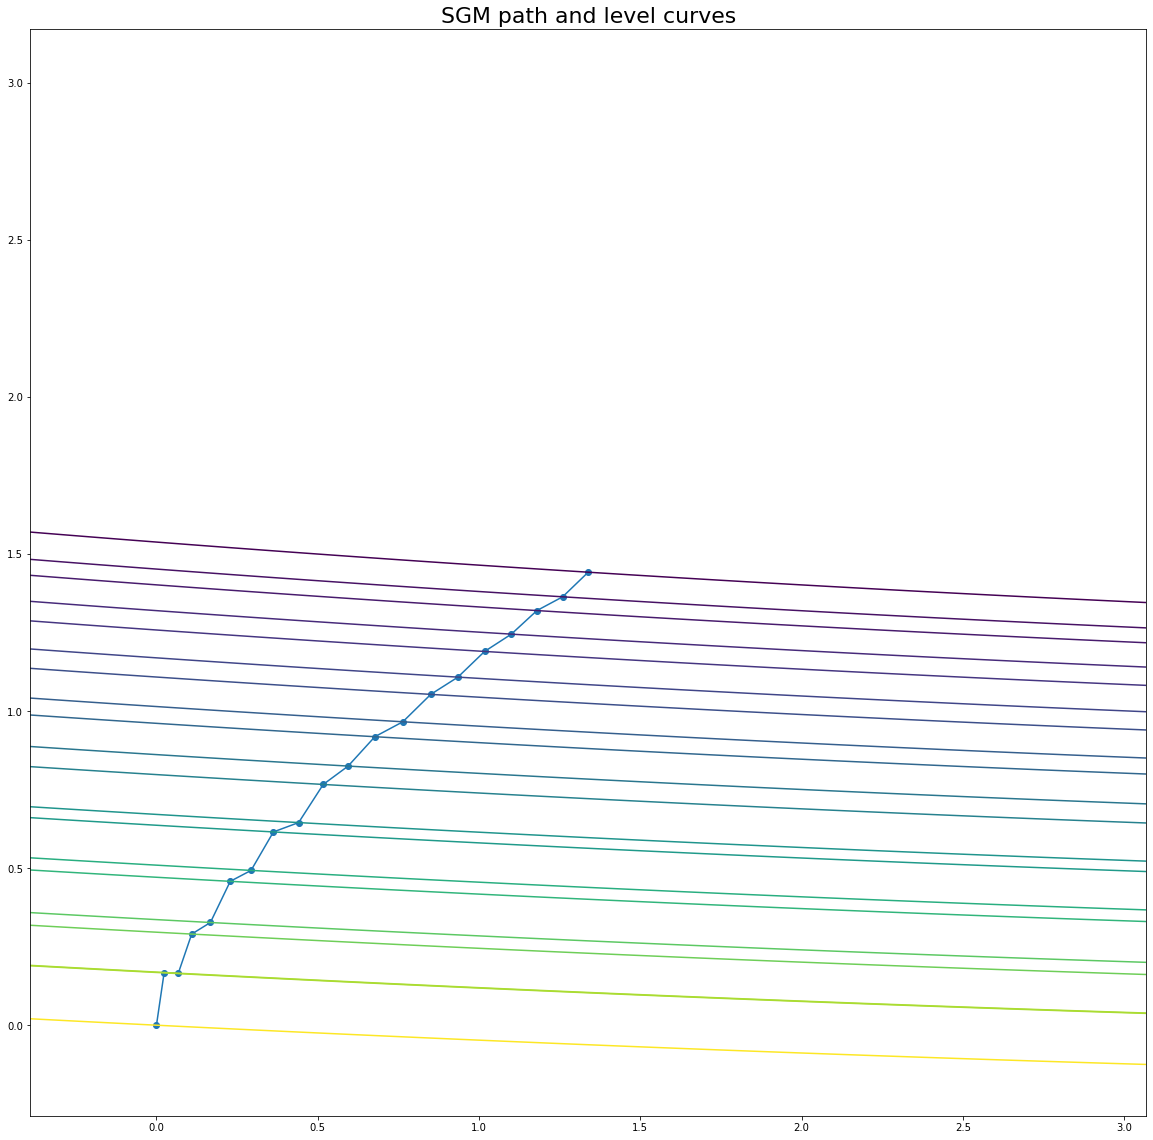

In [351]:
"""
Finds minimum of the function using stochastic gradient descent with Nesterov algorithm.

Аналогична SGD with momentum, но в добавок вычисляет градиент на каждом шаге, не в точке x, а в точке x - b * g, где g - направление спуска на прошлом шаге.

По неизвестным причинам такой спуск работает невероятно плохо. Он либо сходится крайне медленно, либо чрезвычайно быстро расходится. Притом грань между сходимость и расходимостью очень тонкая.

@param b: weight of gradient in previous points
"""
def sgd_nesterov(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = np.zeros(len(x))
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x - b * g, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

a = [10, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 60
lr = [2, 1]
b = [0.9]

points = sgd_nesterov(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with AdaGrad

Precision: [-0.41603413  0.35223629]
Min point: [20.41603413  4.64776371]
Path: [[ 0.          0.        ]
 [19.99999982 19.99999997]
 [16.22478655  0.7277538 ]
 [22.04373652  7.34562632]
 [21.32188089  4.34456038]
 [20.9880927   5.19887638]
 [19.76305659  5.07391765]
 [20.58889518  4.88583395]
 [20.08568559  4.88849998]
 [20.51061007  4.96381641]
 [19.10090809  5.00165951]
 [19.45793632  5.21711652]
 [18.81237483  4.57190642]
 [18.70041591  5.11755458]
 [19.6971487   4.91783098]
 [20.12937309  5.26649188]
 [20.44578246  4.88826886]
 [20.50305821  4.76959234]
 [20.8839366   5.20007144]
 [20.41603413  4.64776371]]


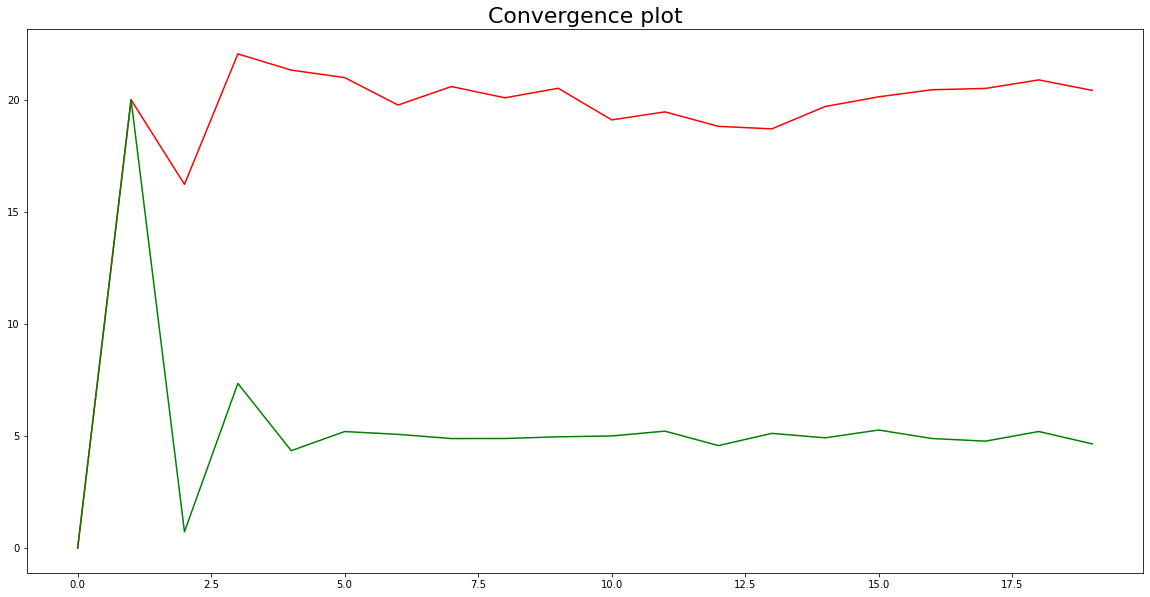

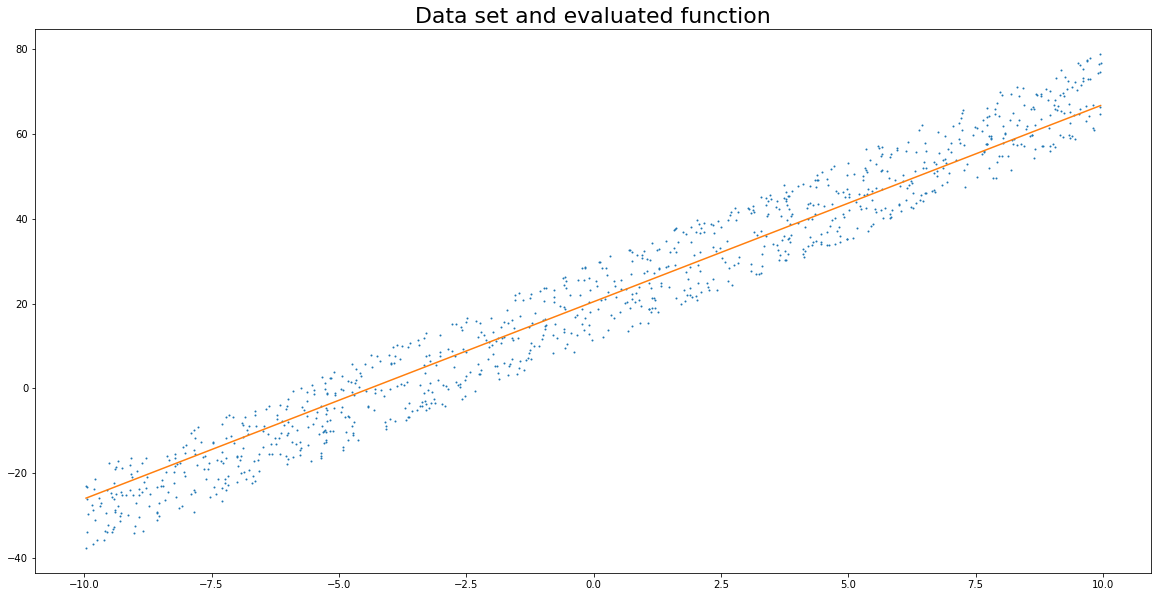

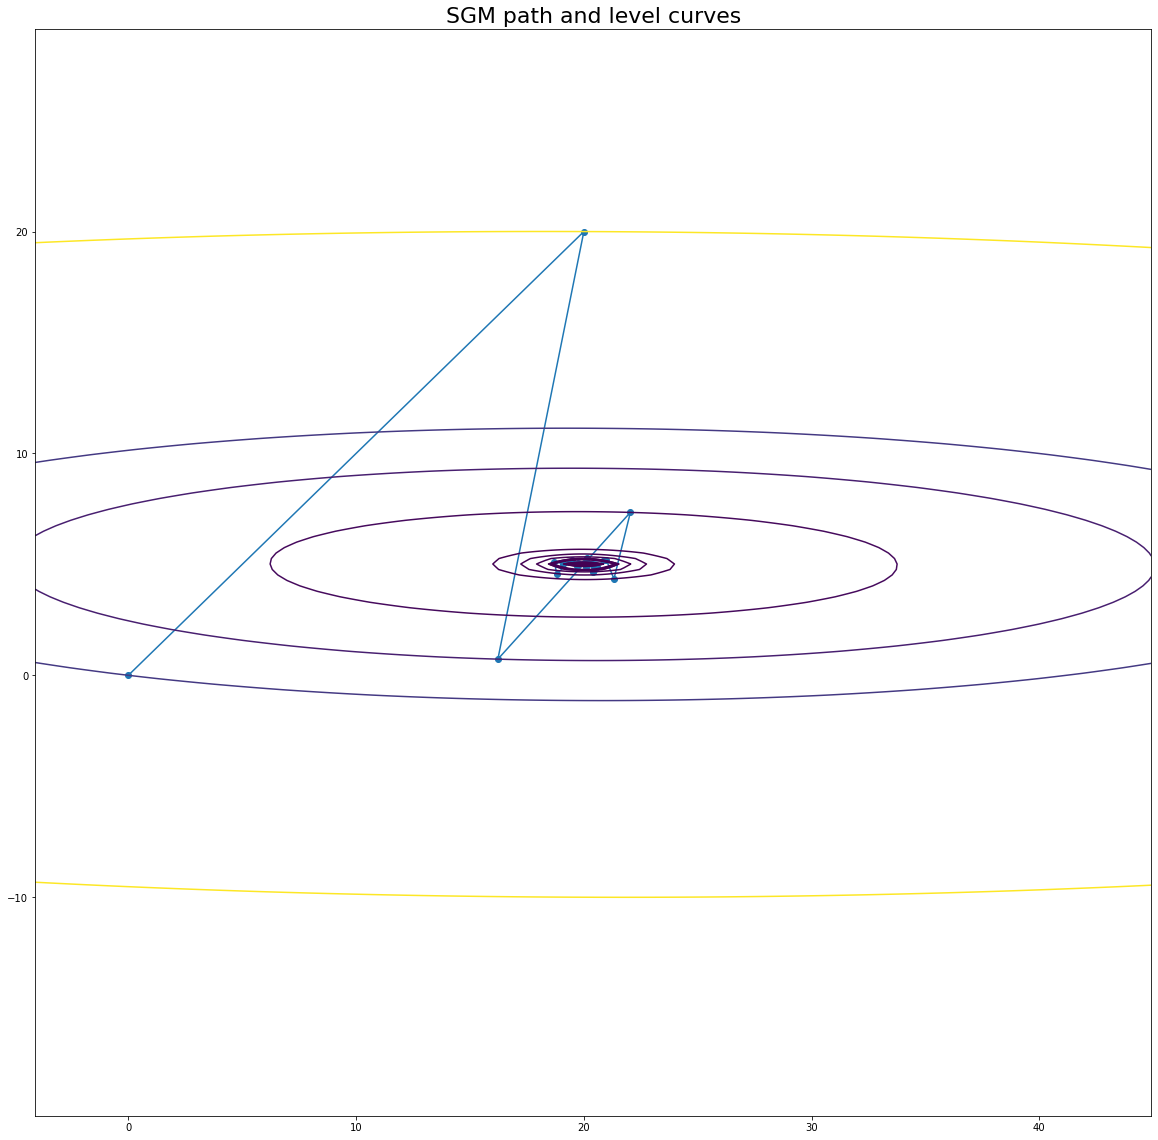

In [352]:
"""
Finds minimum of the function using stochastic gradient descent with AdaGrad (adaptive gradient).

Теперь величина шага накапливается в переменной v. С помощью накопленной величины редактируется размер шага в направлении антиградиента на текущей итерации. Само направление при этом выбирается стандартным образом.

Уменьшает колебания. Даёт возможность использовать одинаковый lr по всем направлениям даже без использования scaler.
"""
def sgd_adagrad(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = np.zeros(len(x))
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v += np.square(g)
        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points

a = [20, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = 1000

points = sgd_adagrad(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with RMSProp

Precision: [0.23429996 0.59990622]
Min point: [14.76570004  4.40009378]
Path: [[ 0.          0.        ]
 [ 3.79473288  3.79473318]
 [ 6.94261034  4.92650585]
 [ 8.94042835  4.91716952]
 [10.27566313  4.96091419]
 [11.37812928  4.93645388]
 [12.15184475  4.97085875]
 [13.21258406  5.16061378]
 [13.46756187  4.69319572]
 [13.65911375  4.51759304]
 [13.58523102  4.92112177]
 [14.50604139  5.09415442]
 [14.07301532  4.94686651]
 [14.86205517  4.86000726]
 [14.5672667   5.47440279]
 [14.33622657  4.76196409]
 [14.51093331  5.37019774]
 [14.74778929  4.24199801]
 [15.32668324  5.34224926]
 [14.76570004  4.40009378]]


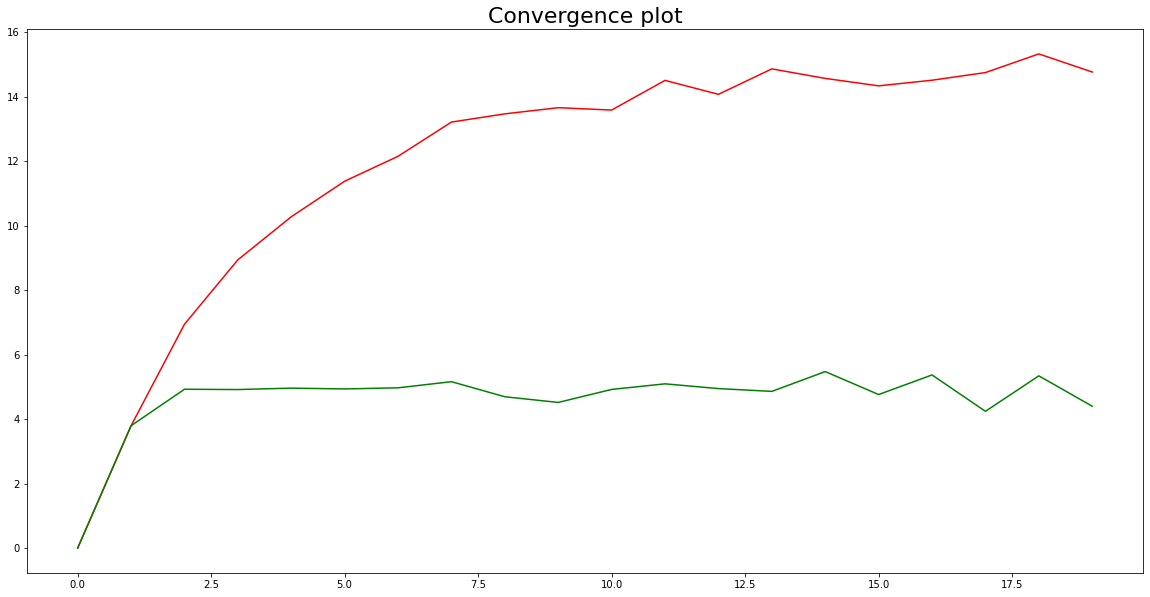

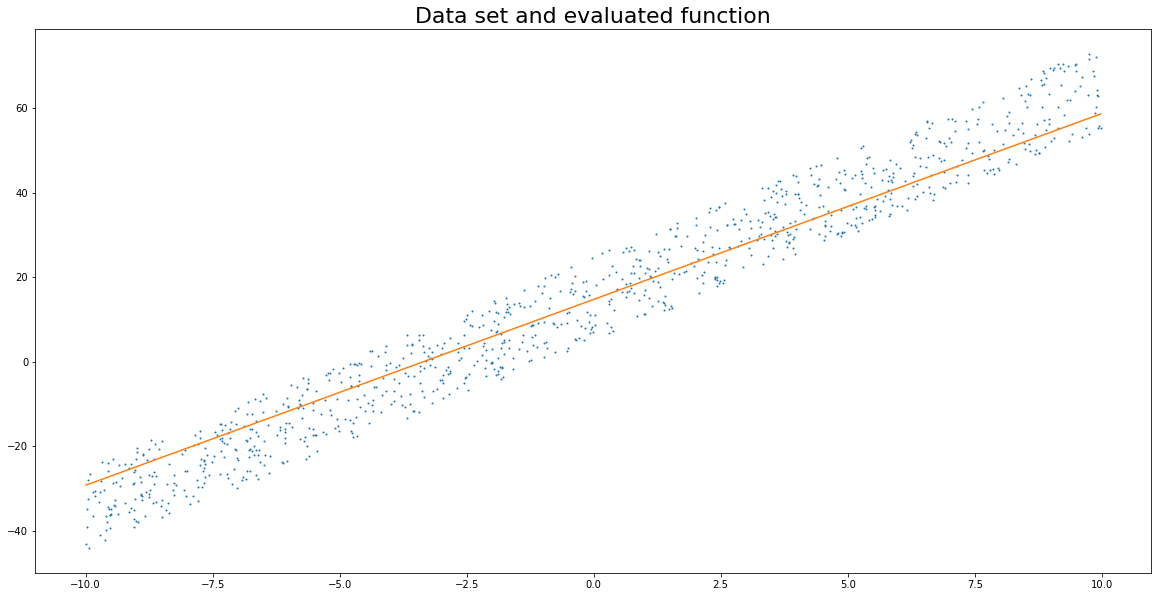

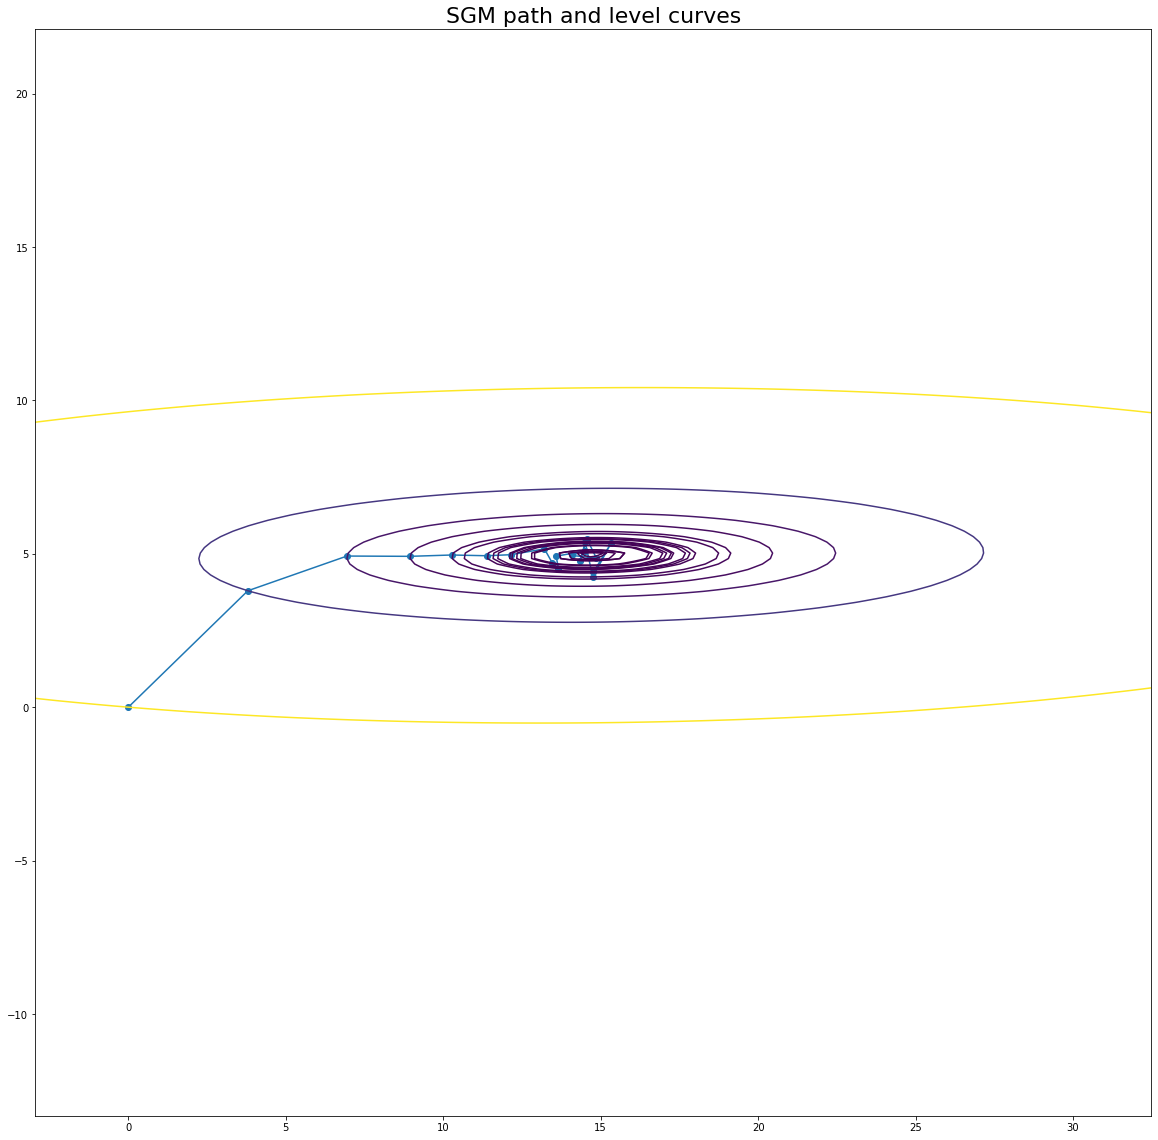

In [353]:
"""
Finds minimum of the function using stochastic gradient descent with rmsprop.

Алгоритм действует аналогично AdaGrad, но теперь шаг накапливается с инерцией, изменяясь, как скользящее среднее шагов на прошлых итерациях.

@param b: weight of steps (euclid norm of gradient) in previous points
"""
def sgd_rmsprop(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b = np.array(b)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v = b * v + (1 - b) * np.square(g)
        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


a = [15, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = 60
b = 0.9

points = sgd_rmsprop(sum_fun, x, epoch, batch_size, lr, b)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## SGD with Adam

Precision: [-1.88984973 -0.11506169]
Min point: [16.88984973  5.11506169]
Path: [[ 0.          0.        ]
 [ 2.85368815  2.85368827]
 [ 5.35794413  4.74594068]
 [ 7.64664914  5.95781121]
 [ 9.49497134  6.35565199]
 [10.96293526  6.32824627]
 [12.4508705   5.99875703]
 [13.59969447  5.43023971]
 [13.97733595  4.95985217]
 [14.81150295  4.69784546]
 [15.30620568  4.85503053]
 [15.67441974  4.88542517]
 [15.72207188  5.0465615 ]
 [15.49811409  5.05215963]
 [14.55029268  4.83292353]
 [14.54171573  5.36039704]
 [14.92660368  5.34588019]
 [14.9433968   4.98338915]
 [15.29833805  4.99544405]
 [16.88984973  5.11506169]]


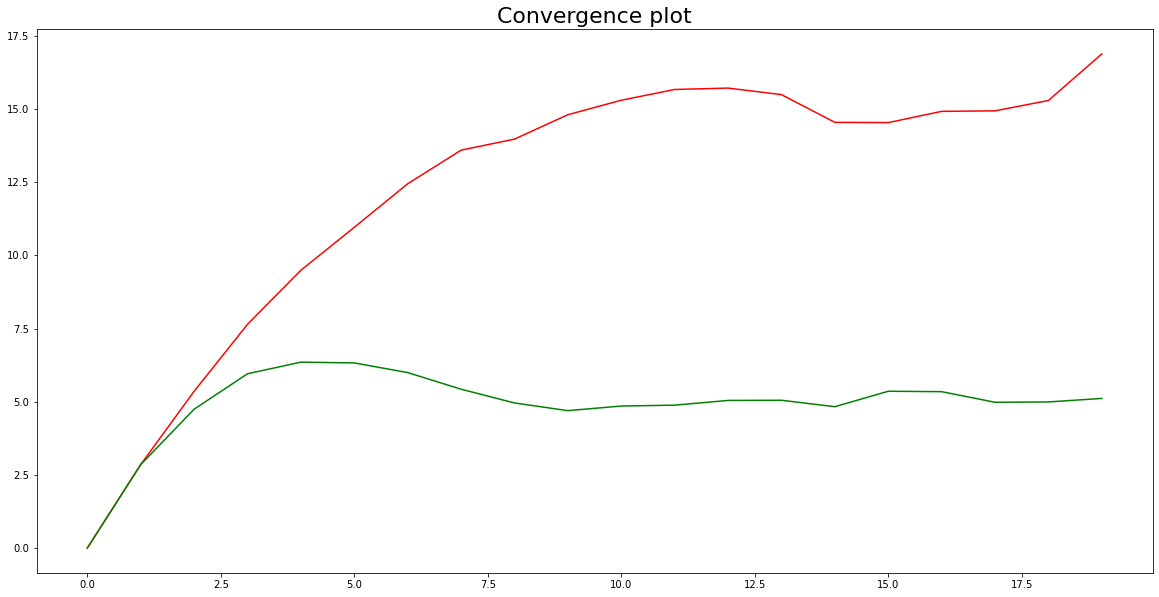

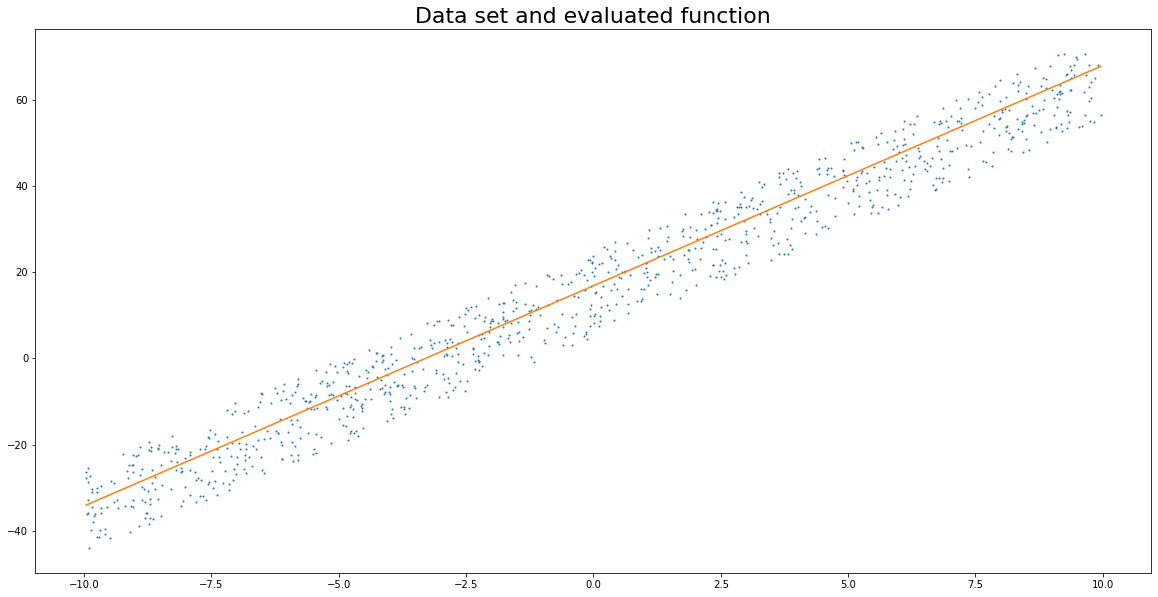

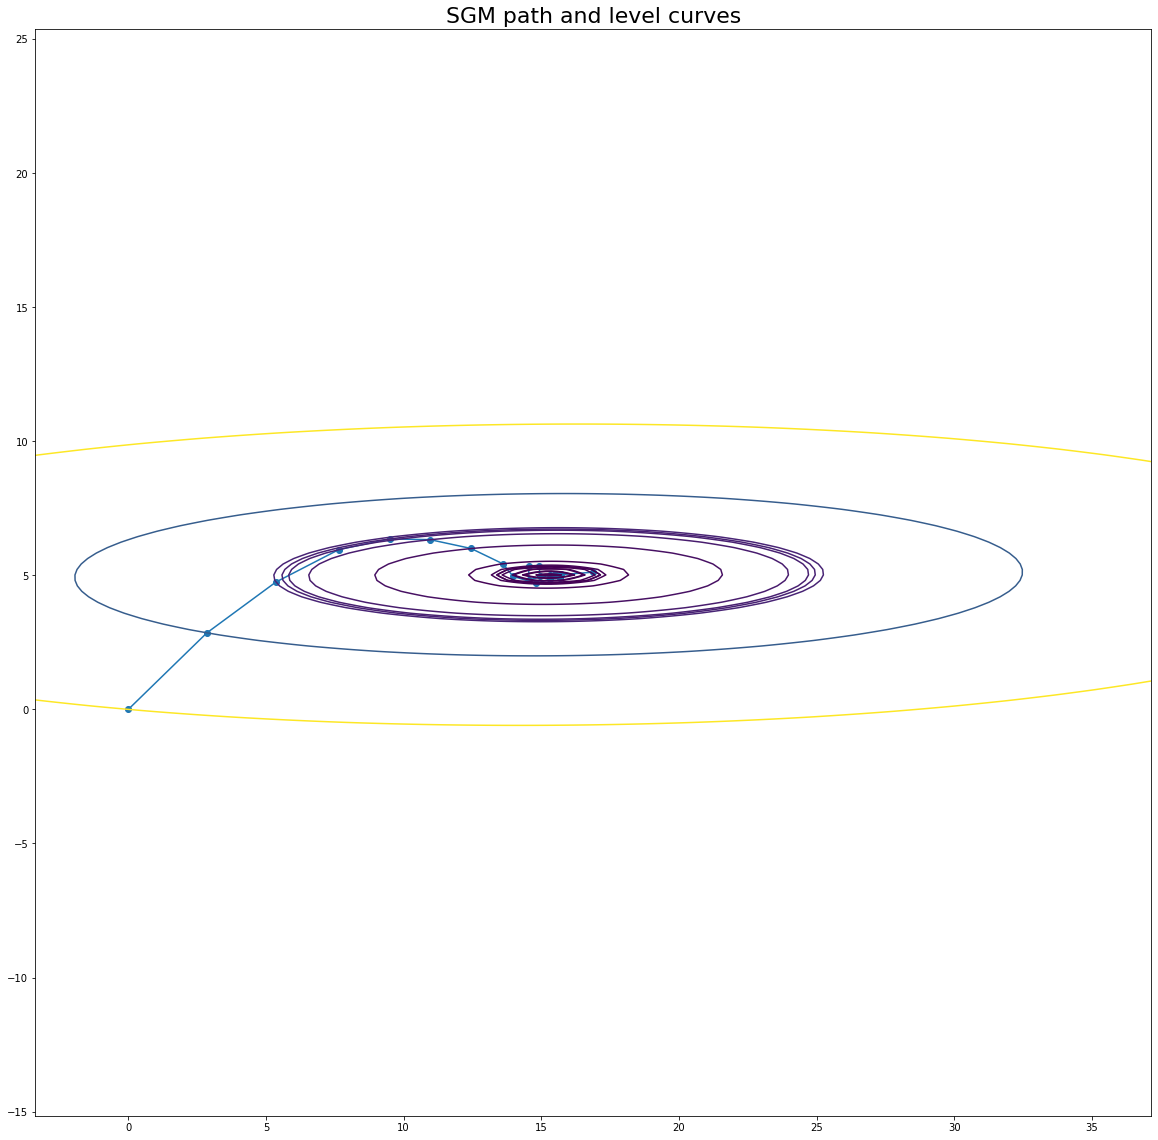

In [354]:
"""
Finds minimum of the function using stochastic gradient descent with adam.

Adam вобрал в себя идеи RMSProp и SGD with momentum. Теперь и величина шага, и направление шага корректируются, как скользящее среднее величины шага и его направления на прошлых итерациях.

Подобный подход позволяет значительно уменьшить колебания спуска вблизи минимума. Более того, этот алгоритм, как и RMSProp, будет хорошо сходиться даже в условиях отсутствия предварительной нормировки данных, с одинаковым lr по всем направлениям (features).

Возможно, этот алгоритм на даёт лучшей сходимости всегда, но он определённо надеждней многих прочих в большинстве случаев.

@param b1: weight of gradient in previous points
@param b2: weight of steps (euclid norm of gradient) in previous points
"""
def sgd_adam(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    m = 0
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points[i] = x
    return points

a = [15, 5]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 60
b1 = 0.5
b2 = 0.7
scheduler = lambda lr: lr * np.exp(-0.05)

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)

print_result(a, points)
plot_convergence(points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)

## Траектория спуска обычного SGD для одномерного пространства регрессоров
На графике также отображены линии равного уровня минимизируемой функции

Precision: [ 0.09858509 -0.045896  ]
Min point: [ 9.90141491 -2.954104  ]
Path: [[ 0.          0.        ]
 [ 1.05280342 -0.30160683]
 [ 1.45990518 -0.54189545]
 [ 2.64528486 -0.85059138]
 [ 3.26847924 -1.0145001 ]
 [ 3.95857305 -1.29149593]
 [ 4.23835369 -1.42909934]
 [ 4.75480931 -1.61021507]
 [ 5.08877556 -1.74656238]
 [ 5.58348872 -1.86924012]
 [ 5.90737265 -2.03997251]
 [ 6.25192533 -2.13551026]
 [ 6.71375625 -2.21286596]
 [ 7.03591391 -2.30496589]
 [ 7.0515134  -2.41343959]
 [ 7.22420247 -2.48335767]
 [ 7.43631489 -2.56504035]
 [ 7.51671082 -2.60064488]
 [ 7.70800163 -2.67693078]
 [ 7.94252322 -2.70941707]
 [ 8.13976757 -2.75503342]
 [ 8.47139902 -2.83646055]
 [ 8.70725358 -2.82081293]
 [ 8.83796269 -2.83052895]
 [ 8.88255795 -2.85733255]
 [ 9.07243951 -2.84293193]
 [ 9.11407525 -2.84896715]
 [ 9.13887681 -2.86432826]
 [ 9.12641401 -2.88805934]
 [ 9.231405   -2.9248987 ]
 [ 9.31040982 -2.93803733]
 [ 9.39734407 -2.93519798]
 [ 9.52064158 -2.93807339]
 [ 9.58977268 -2.96834832]
 [

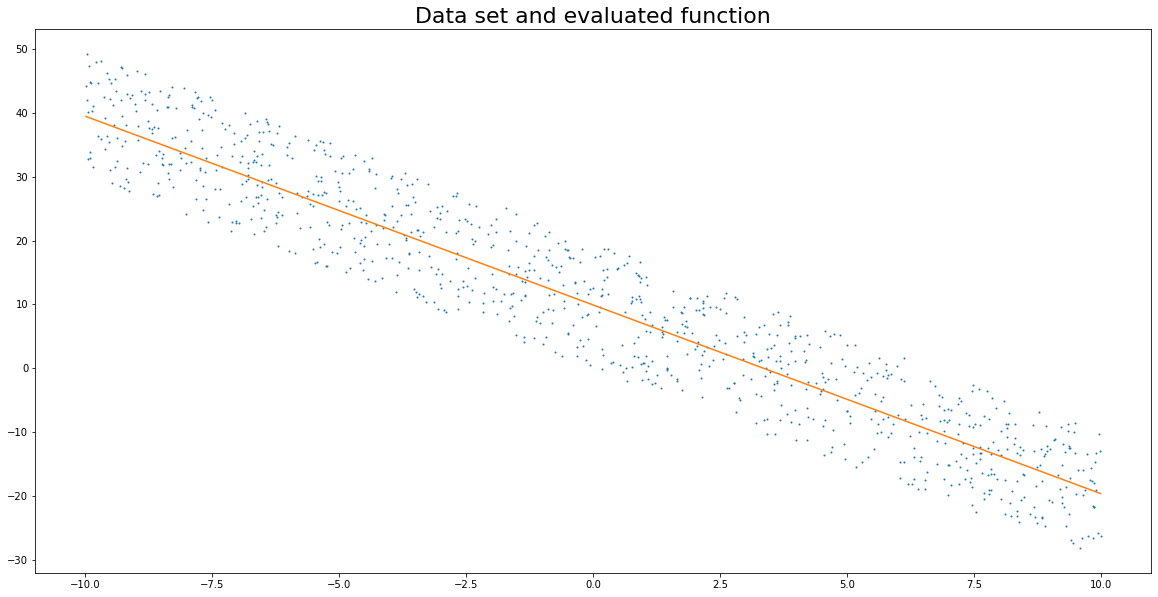

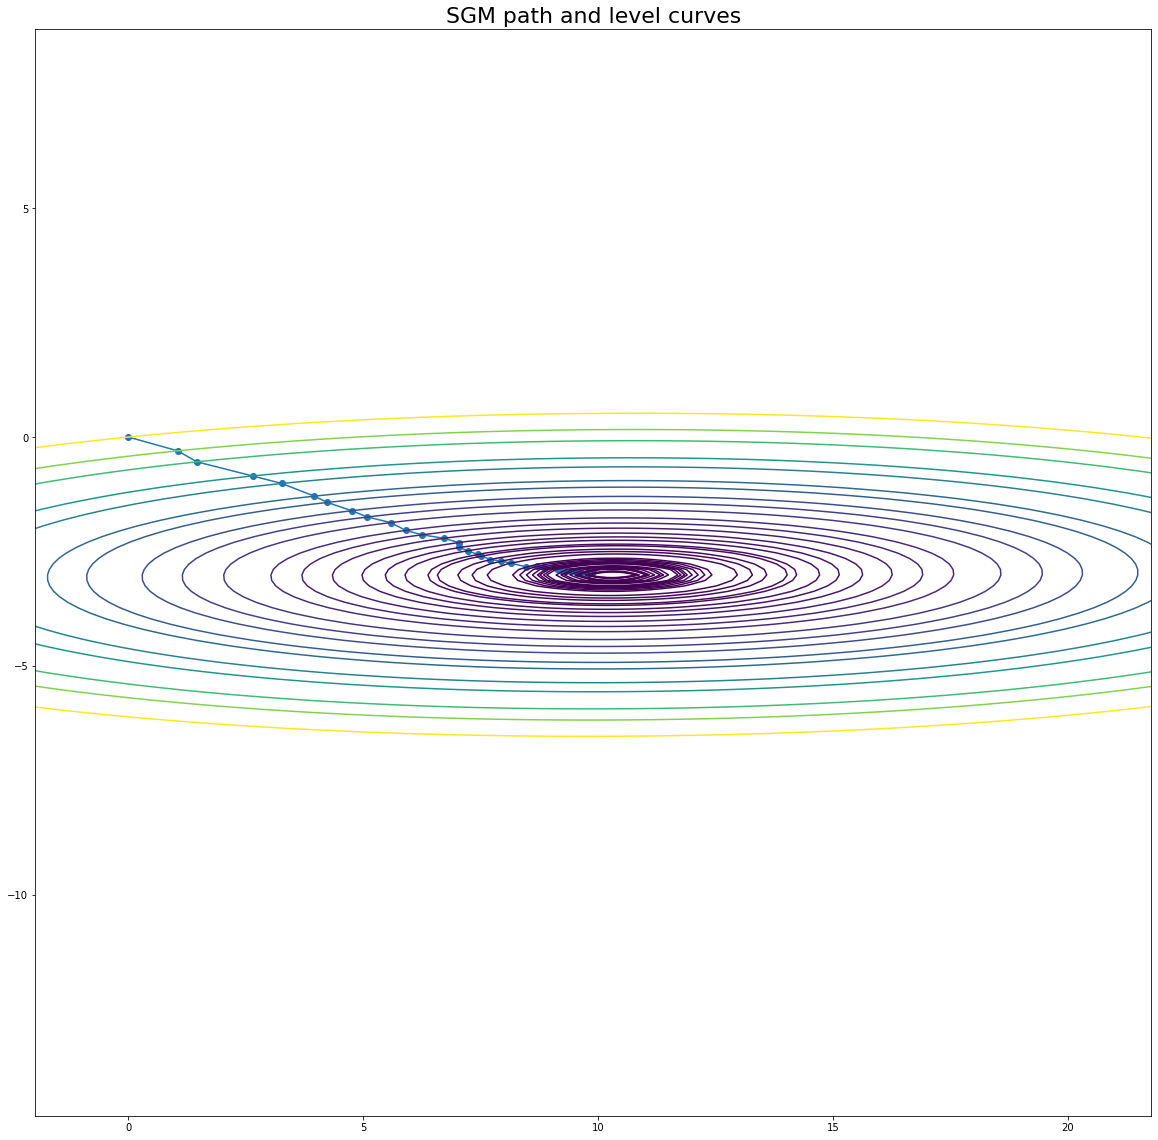

In [355]:
a = [10, -3]
t, ft = generate_dataset(a, 10, 1000, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 40
batch_size = 20
lr = [70, 3]

points = sgd(sum_fun, x, epoch, batch_size, lr)

print_result(a, points)
plot_dataset_and_function(t, ft, points[-1])
plot_path_contours(sum_fun, points)